In [1]:

!pip install --quiet requests beautifulsoup4 lxml pandas scikit-learn matplotlib joblib

!pip install --quiet rapidfuzz shap


In [2]:
import os
import re
import time
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from difflib import get_close_matches
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from joblib import dump, load

# Create folders
os.makedirs("data", exist_ok=True)
os.makedirs("model", exist_ok=True)

# polite headers
HEADERS = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0 Safari/537.36"}


In [12]:
import math

def clean_team_name(name):
    if pd.isna(name): return name
    # remove common trailing notes like " (Loan)" or " (Man City)" etc.
    name = re.sub(r"\s*\(.*?\)", "", str(name)).strip()
    # remove weird characters
    return re.sub(r"[^A-Za-z0-9 &\-\.\']+", "", name).strip()

def parse_money_to_eur(s):
    """
    Parse strings like '€1.05bn', '€450.00m', '€12,000,000' into numeric Euros (float).
    Returns float or np.nan if not valid.
    """
    try:
        if pd.isna(s):
            return np.nan
        s = str(s).lower().strip().replace(" ", "").replace(",", "")
        if s in ["", "-", "—", "...", "n/a", "nan"]:
            return np.nan

        # remove currency symbols
        s = s.replace("€", "").replace("£", "")

        # match number + suffix (bn, m, k)
        m = re.match(r"([0-9]*\.?[0-9]+)(bn|b|m|k)?", s)
        if not m:
            return np.nan

        value = float(m.group(1))
        suffix = m.group(2)

        if suffix in ("bn", "b"):
            return value * 1_000_000_000
        if suffix == "m":
            return value * 1_000_000
        if suffix == "k":
            return value * 1_000
        return value
    except Exception:
        return np.nan



In [13]:
def scrape_fbref_table(season_url):
    print("Fetching:", season_url)
    r = requests.get(season_url, headers=HEADERS, timeout=20)
    r.raise_for_status()
    html = r.text

    # try pandas.read_html first (easy)
    try:
        tables = pd.read_html(html)
        # choose table by heuristic: contains 'Squad' or 'Team' column and numeric Points or Pts
        for df in tables:
            cols = [str(c).lower() for c in df.columns]
            if any(x in cols for x in ("squad","team","club")) and any('pts' in c or 'points' in c or 'p'==c for c in cols):
                print("Using pandas.read_html table")
                return df
    except Exception as e:
        print("pandas.read_html failed or didn't find right table:", e)

    # fallback: parse HTML with BeautifulSoup and build table
    soup = BeautifulSoup(html, "lxml")
    table = soup.find("table")
    if not table:
        raise RuntimeError("No table found on page. Open the URL in a browser and inspect the table.")
    rows = []
    for tr in table.find_all("tr"):
        cols = [td.get_text(strip=True) for td in tr.find_all(["td","th"])]
        if cols:
            rows.append(cols)
    df = pd.DataFrame(rows)
    return df

# Example usage: (replace URL with correct FBref season page for the Premier League)
example_url = "https://fbref.com/en/comps/9/2023-2024/2023-2024-Premier-League-Stats"
df_example = scrape_fbref_table(example_url)
df_example.head(10)


Fetching: https://fbref.com/en/comps/9/2023-2024/2023-2024-Premier-League-Stats
Using pandas.read_html table


,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,xG,xGA,xGD,xGD/90,Attendance,Top Team Scorer,Goalkeeper,Notes
0,1,Manchester City,38,28,7,3,96,34,62,91,2.39,80.5,35.6,44.9,1.18,53012,Erling Haaland - 27,Ederson,→ Champions League via league finish
1,2,Arsenal,38,28,5,5,91,29,62,89,2.34,76.1,27.9,48.2,1.27,60236,Bukayo Saka - 16,David Raya,→ Champions League via league finish
2,3,Liverpool,38,24,10,4,86,41,45,82,2.16,87.8,45.7,42.0,1.11,55979,Mohamed Salah - 18,Alisson,→ Champions League via league finish
3,4,Aston Villa,38,20,8,10,76,61,15,68,1.79,63.3,59.9,3.4,0.09,41858,Ollie Watkins - 19,Emiliano Martínez,→ Champions League via league finish
4,5,Tottenham,38,20,6,12,74,61,13,66,1.74,68.2,63.4,4.8,0.13,61482,Son Heung-min - 17,Guglielmo Vicario,→ Europa League via league finish
5,6,Chelsea,38,18,9,11,77,63,14,63,1.66,74.5,58.1,16.4,0.43,39524,Cole Palmer - 22,Đorđe Petrović,→ Conference League via league finish
6,7,Newcastle Utd,38,18,6,14,85,62,23,60,1.58,76.0,61.4,14.6,0.38,52125,Alexander Isak - 21,Martin Dúbravka,NaN
7,8,Manchester Utd,38,18,6,14,57,58,-1,60,1.58,56.5,68.9,-12.5,-0.33,73533,"Rasmus Højlund, Bruno Fernandes - 10",André Onana,→ Europa League via cup win
8,9,West Ham,38,14,10,14,60,74,-14,52,1.37,52.3,71.1,-18.8,-0.49,62567,Jarrod Bowen - 16,Alphonse Areola,NaN
9,10,Crystal Palace,38,13,10,15,57,58,-1,49,1.29,48.6,52.0,-3.4,-0.09,24932,Jean-Philippe Mateta - 16,Sam Johnstone,NaN


In [14]:
# Inspect columns: sometimes multi-index columns appear; flatten them if needed
def flatten_columns(df):
    # if columns are tuples (multiindex) flatten
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [' '.join([str(x) for x in col]).strip() for col in df.columns.values]
    return df

df_fbref = flatten_columns(df_example)
# try to find the core columns: 'Squad' or 'Team' and 'Pts' or 'Rk'/position etc.
print("Columns:", df_fbref.columns.tolist()[:40])
# Rename the likely 'Squad' column to 'team'
possible_team_cols = [c for c in df_fbref.columns if 'squad' in c.lower() or 'team' in c.lower() or 'club' in c.lower()]
team_col = possible_team_cols[0] if possible_team_cols else df_fbref.columns[0]
df_fbref = df_fbref.rename(columns={team_col: 'team'})
# Clean team names
df_fbref['team'] = df_fbref['team'].apply(clean_team_name)

# Save raw fbref CSV for that season
df_fbref.to_csv("data/fbref_2023-24_raw.csv", index=False)
print("Saved data/fbref_2023-24_raw.csv")


Columns: ['Rk', 'Squad', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Pts/MP', 'xG', 'xGA', 'xGD', 'xGD/90', 'Attendance', 'Top Team Scorer', 'Goalkeeper', 'Notes']
Saved data/fbref_2023-24_raw.csv


In [15]:
def scrape_transfermarkt_market_values(url):
    print("Fetching:", url)
    r = requests.get(url, headers=HEADERS, timeout=20)
    r.raise_for_status()
    html = r.text
    try:
        tables = pd.read_html(html)
        # pick table containing 'Club' or a € sign
        for t in tables:
            txt = " ".join(t.astype(str).columns).lower()
            if 'club' in txt or t.astype(str).apply(lambda col: col.str.contains('€').any()).any():
                print("Using pandas table from Transfermarkt")
                return t
        # fallback: return first table
        return tables[0]
    except Exception as e:
        print("read_html failed:", e)
        # fallback to BeautifulSoup scraping if needed
        soup = BeautifulSoup(html, "lxml")
        table = soup.find('table')
        rows = []
        if not table:
            raise RuntimeError("No table found on Transfermarkt page.")
        for tr in table.find_all('tr'):
            cols = [td.get_text(strip=True) for td in tr.find_all(['td','th'])]
            if cols:
                rows.append(cols)
        return pd.DataFrame(rows)

# Example Transfermarkt URL (league market values page)
tm_url = "https://www.transfermarkt.com/premier-league/marktwerte/wettbewerb/GB1"
df_tm = scrape_transfermarkt_market_values(tm_url)
df_tm.head(10)


Fetching: https://www.transfermarkt.com/premier-league/marktwerte/wettbewerb/GB1
read_html failed: sequence item 0: expected str instance, int found


,0,1
0,Position:,All positionsGoalkeepersDefendersMidfieldersSt...
1,Main positions:,All positionsGoalkeeperSweeperCentre-BackLeft-...
2,Age group:,Allu19u20u21u2323-30o30o32o34
3,Nationality:,AllAfghanistanAlbaniaAlgeriaAmerican SamoaAmer...


In [16]:
df_tm = flatten_columns(df_tm)

# Convert all column names to strings
cols = [str(c).lower() for c in df_tm.columns]

club_col = None
value_col = None

for c in df_tm.columns:
    c_str = str(c).lower()
    if any(x in c_str for x in ['club','verein','team']):
        club_col = c
    # check if column has euro values or "market"
    if 'marktwert' in c_str or 'market' in c_str:
        value_col = c

# If nothing found, fall back to first and last columns
if club_col is None:
    club_col = df_tm.columns[0]
if value_col is None:
    value_col = df_tm.columns[-1]

df_tm = df_tm.rename(columns={club_col: 'team', value_col: 'market_value_raw'})
df_tm['team'] = df_tm['team'].apply(clean_team_name)
df_tm['market_value_eur'] = df_tm['market_value_raw'].apply(parse_money_to_eur)


# Save cleaned file
df_tm.to_csv("data/transfermarkt_pl_raw.csv", index=False)
print("Saved data/transfermarkt_pl_raw.csv")
df_tm.head()


Saved data/transfermarkt_pl_raw.csv


,team,market_value_raw,market_value_eur
0,Position,All positionsGoalkeepersDefendersMidfieldersSt...,NaN
1,Main positions,All positionsGoalkeeperSweeperCentre-BackLeft-...,NaN
2,Age group,Allu19u20u21u2323-30o30o32o34,NaN
3,Nationality,AllAfghanistanAlbaniaAlgeriaAmerican SamoaAmer...,NaN


In [18]:
# Example: assemble dataframes you scraped for multiple seasons into one master df
# For demonstration we'll assume you have df_fbref for season 2023-24 and will create minimal columns
# In practice, repeat step 3 for multiple seasons and append them, ensuring a 'season' column exists.

# Add a season column to df_fbref (customize as needed)
df_fbref['season'] = "2023-2024"
# Try to find points/gd/gf/ga columns (heuristic)
possible_points = [c for c in df_fbref.columns if 'pt' in c.lower() or 'pts' in c.lower() or 'points' in c.lower()]
possible_gf = [c for c in df_fbref.columns if re.search(r'\b(gf|goalsfor|f)\b', c.lower())]
possible_ga = [c for c in df_fbref.columns if re.search(r'\b(ga|goalsagainst|a)\b', c.lower())]
possible_pos = [c for c in df_fbref.columns if re.search(r'\b(pos|rk|rank)\b', c.lower())]

# fallback column names if not found (user may need to rename manually)
print("Detected heuristics -> points:", possible_points, "gf:", possible_gf, "ga:", possible_ga, "pos:", possible_pos)
# For demonstration, create numeric columns if present
if possible_points:
    df_fbref['points'] = pd.to_numeric(df_fbref[possible_points[0]], errors='coerce')
if possible_gf:
    df_fbref['gf'] = pd.to_numeric(df_fbref[possible_gf[0]], errors='coerce')
if possible_ga:
    df_fbref['ga'] = pd.to_numeric(df_fbref[possible_ga[0]], errors='coerce')
if possible_pos:
    df_fbref['pos'] = pd.to_numeric(df_fbref[possible_pos[0]], errors='coerce')

# Minimal merged example: join team-level market values    (use fuzzy matching if names differ)
market_df = pd.read_csv("data/transfermarkt_pl_raw.csv")
market_names = market_df['team'].dropna().unique().tolist()
df_fbref['tm_team'] = df_fbref['team'].apply(lambda x: fuzzy_match(x, market_names) or x)
merged = df_fbref.merge(market_df[['team','market_value_eur']], left_on='tm_team', right_on='team', how='left', suffixes=('','_tm'))

# Save merged
merged.to_csv("data/merged_2023-24.csv", index=False)
print("Saved data/merged_2023-24.csv")
merged.head()



Detected heuristics -> points: ['Pts', 'Pts/MP'] gf: ['GF'] ga: ['GA'] pos: ['Rk']
Saved data/merged_2023-24.csv


,Rk,team,MP,W,D,L,GF,GA,GD,Pts,...,Goalkeeper,Notes,season,points,gf,ga,pos,tm_team,team_tm,market_value_eur
0,1,Manchester City,38,28,7,3,96,34,62,91,...,Ederson,→ Champions League via league finish,2023-2024,91,96,34,1,Manchester City,NaN,NaN
1,2,Arsenal,38,28,5,5,91,29,62,89,...,David Raya,→ Champions League via league finish,2023-2024,89,91,29,2,Arsenal,NaN,NaN
2,3,Liverpool,38,24,10,4,86,41,45,82,...,Alisson,→ Champions League via league finish,2023-2024,82,86,41,3,Liverpool,NaN,NaN
3,4,Aston Villa,38,20,8,10,76,61,15,68,...,Emiliano Martínez,→ Champions League via league finish,2023-2024,68,76,61,4,Aston Villa,NaN,NaN
4,5,Tottenham,38,20,6,12,74,61,13,66,...,Guglielmo Vicario,→ Europa League via league finish,2023-2024,66,74,61,5,Tottenham,NaN,NaN


In [22]:
season_urls = {
    "2018-2019": "https://fbref.com/en/comps/9/1889/2018-2019-Premier-League-Stats",
    "2019-2020": "https://fbref.com/en/comps/9/3232/2019-2020-Premier-League-Stats",
    "2020-2021": "https://fbref.com/en/comps/9/10728/2020-2021-Premier-League-Stats",
    "2021-2022": "https://fbref.com/en/comps/9/11160/2021-2022-Premier-League-Stats",
    "2022-2023": "https://fbref.com/en/comps/9/2022-2023/2022-2023-Premier-League-Stats",
    "2023-2024": "https://fbref.com/en/comps/9/2023-2024/2023-2024-Premier-League-Stats"
}



In [23]:
all_seasons = []

for season, url in season_urls.items():
    try:
        df_season = scrape_fbref_table(url)  # reuse the function from Cell 3
        df_season = flatten_columns(df_season)

        # Detect team column
        team_col = [c for c in df_season.columns if "squad" in str(c).lower() or "team" in str(c).lower() or "club" in str(c).lower()]
        team_col = team_col[0] if team_col else df_season.columns[0]
        df_season = df_season.rename(columns={team_col: "team"})
        df_season["team"] = df_season["team"].apply(clean_team_name)

        # Detect points column
        pts_col = [c for c in df_season.columns if "pts" in str(c).lower() or "points" in str(c).lower()]
        if pts_col:
            df_season["points"] = pd.to_numeric(df_season[pts_col[0]], errors="coerce")

        # Detect rank/pos column
        pos_col = [c for c in df_season.columns if "rk" in str(c).lower() or "pos" in str(c).lower()]
        if pos_col:
            df_season["pos"] = pd.to_numeric(df_season[pos_col[0]], errors="coerce")

        df_season["season"] = season
        all_seasons.append(df_season[["team","points","pos","season"]])
        print(f"✅ Scraped {season}")
        time.sleep(2)  # be polite to FBref
    except Exception as e:
        print(f"⚠️ Failed {season}:", e)

df_fbref_all = pd.concat(all_seasons, ignore_index=True)
df_fbref_all.to_csv("data/fbref_all_seasons.csv", index=False)
print("Saved data/fbref_all_seasons.csv")
df_fbref_all.head()


Fetching: https://fbref.com/en/comps/9/1889/2018-2019-Premier-League-Stats
Using pandas.read_html table
✅ Scraped 2018-2019
Fetching: https://fbref.com/en/comps/9/3232/2019-2020-Premier-League-Stats
Using pandas.read_html table
✅ Scraped 2019-2020
Fetching: https://fbref.com/en/comps/9/10728/2020-2021-Premier-League-Stats
Using pandas.read_html table
✅ Scraped 2020-2021
Fetching: https://fbref.com/en/comps/9/11160/2021-2022-Premier-League-Stats
Using pandas.read_html table
✅ Scraped 2021-2022
Fetching: https://fbref.com/en/comps/9/2022-2023/2022-2023-Premier-League-Stats
Using pandas.read_html table
✅ Scraped 2022-2023
Fetching: https://fbref.com/en/comps/9/2023-2024/2023-2024-Premier-League-Stats
Using pandas.read_html table
✅ Scraped 2023-2024
Saved data/fbref_all_seasons.csv


,team,points,pos,season
0,Manchester City,98,1,2018-2019
1,Liverpool,97,2,2018-2019
2,Chelsea,72,3,2018-2019
3,Tottenham,71,4,2018-2019
4,Arsenal,70,5,2018-2019


In [24]:
# Find champion of each season (pos == 1)
champions = df_fbref_all[df_fbref_all["pos"] == 1][["season","team"]]
champions = champions.sort_values("season")

# Build dict: season -> champion of that season
champion_dict = dict(zip(champions["season"], champions["team"]))

# Now, for each row, mark if this team will win the *next* season
def get_next_champion(team, season):
    # find what the next season is
    seasons_sorted = sorted(champion_dict.keys())
    if season not in seasons_sorted:
        return 0
    idx = seasons_sorted.index(season)
    if idx+1 < len(seasons_sorted):
        next_season = seasons_sorted[idx+1]
        return 1 if champion_dict[next_season] == team else 0
    return 0  # last season has no "next"

df_fbref_all["won_next"] = df_fbref_all.apply(lambda r: get_next_champion(r["team"], r["season"]), axis=1)

df_fbref_all.to_csv("data/fbref_all_with_labels.csv", index=False)
print("Saved data/fbref_all_with_labels.csv")
df_fbref_all.tail(20)


Saved data/fbref_all_with_labels.csv


,team,points,pos,season,won_next
100,Manchester City,91,1,2023-2024,0
101,Arsenal,89,2,2023-2024,0
102,Liverpool,82,3,2023-2024,0
103,Aston Villa,68,4,2023-2024,0
104,Tottenham,66,5,2023-2024,0
105,Chelsea,63,6,2023-2024,0
106,Newcastle Utd,60,7,2023-2024,0
107,Manchester Utd,60,8,2023-2024,0
108,West Ham,52,9,2023-2024,0
109,Crystal Palace,49,10,2023-2024,0


In [25]:
df_market = pd.read_csv("data/transfermarkt_pl_raw.csv")
df_fbref_all["tm_team"] = df_fbref_all["team"].apply(lambda x: fuzzy_match(x, df_market["team"].tolist()))
df_all_merged = df_fbref_all.merge(df_market[["team","market_value_eur"]], left_on="tm_team", right_on="team", how="left", suffixes=("","_tm"))

df_all_merged.to_csv("data/all_features.csv", index=False)
df_all_merged.head()


,team,points,pos,season,won_next,tm_team,team_tm,market_value_eur
0,Manchester City,98,1,2018-2019,0,None,NaN,NaN
1,Liverpool,97,2,2018-2019,1,None,NaN,NaN
2,Chelsea,72,3,2018-2019,0,None,NaN,NaN
3,Tottenham,71,4,2018-2019,0,None,NaN,NaN
4,Arsenal,70,5,2018-2019,0,None,NaN,NaN


In [29]:
# We assume you already have df_fbref_all (multi-season data from FBref scraping)
# Columns should include: ['team', 'points', 'pos', 'season']

# Step 1: Find champions of each season (pos == 1)
champions = df_fbref_all[df_fbref_all["pos"] == 1][["season", "team"]].copy()
champions = champions.sort_values("season")
print("Champions by season:\n", champions)

# Step 2: Build dict: for each season S, who was the champion in season S+1?
seasons_sorted = sorted(champions["season"].unique())
champion_next = {}

for i in range(len(seasons_sorted) - 1):
    this_season = seasons_sorted[i]
    next_season = seasons_sorted[i + 1]
    champion_next[this_season] = champions.loc[champions["season"] == next_season, "team"].values[0]

print("\nChampion_next mapping:", champion_next)

# Step 3: Assign won_next = 1 if this team will be champion next season
def get_won_next(row):
    champ = champion_next.get(row["season"], None)
    return 1 if champ == row["team"] else 0

df_fbref_all["won_next"] = df_fbref_all.apply(get_won_next, axis=1)

# Save
df_fbref_all.to_csv("data/fbref_all_with_labels.csv", index=False)
print("\n✅ Added 'won_next' column")
print(df_fbref_all[["season", "team", "pos", "won_next"]].head(20))


Champions by season:
         season             team
0    2018-2019  Manchester City
20   2019-2020        Liverpool
40   2020-2021  Manchester City
60   2021-2022  Manchester City
80   2022-2023  Manchester City
100  2023-2024  Manchester City

Champion_next mapping: {'2018-2019': 'Liverpool', '2019-2020': 'Manchester City', '2020-2021': 'Manchester City', '2021-2022': 'Manchester City', '2022-2023': 'Manchester City'}

✅ Added 'won_next' column
       season             team  pos  won_next
0   2018-2019  Manchester City    1         0
1   2018-2019        Liverpool    2         1
2   2018-2019          Chelsea    3         0
3   2018-2019        Tottenham    4         0
4   2018-2019          Arsenal    5         0
5   2018-2019   Manchester Utd    6         0
6   2018-2019           Wolves    7         0
7   2018-2019          Everton    8         0
8   2018-2019   Leicester City    9         0
9   2018-2019         West Ham   10         0
10  2018-2019          Watford   11       

In [30]:
print(df_fbref_all["won_next"].value_counts())


won_next
0    115
1      5
Name: count, dtype: int64


In [32]:
# Use FBref-only data (ignore market values for now)
df = df_fbref_all.copy()
print("Using df_fbref_all (points + pos only)")

# Ensure numeric
for c in ["points", "pos"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Optional GD if GF/GA exist
if "gf" in df.columns and "ga" in df.columns:
    df["gd"] = df["gf"] - df["ga"]

# Features (skip market_value_eur since it's mostly NaN)
feature_cols = [c for c in ["points", "pos", "gd"] if c in df.columns]
print("✅ Using features:", feature_cols)

# Drop rows without label
df_model = df.dropna(subset=["won_next"] + feature_cols)
X = df_model[feature_cols].fillna(0)
y = df_model["won_next"].astype(int)

print("✅ Training dataset shape:", X.shape)
print("Label counts:\n", y.value_counts())


Using df_fbref_all (points + pos only)
✅ Using features: ['points', 'pos']
✅ Training dataset shape: (120, 2)
Label counts:
 won_next
0    115
1      5
Name: count, dtype: int64


In [33]:
clf = RandomForestClassifier(
    n_estimators=200, 
    random_state=42, 
    class_weight="balanced"   # helps with imbalance (5 winners vs 115 losers)
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, cv=cv, scoring="f1")
print("CV F1 scores:", scores, "Mean:", scores.mean())

# Train final model
clf.fit(X, y)
dump(clf, "model/pl_winner_model.pkl")
print("✅ Model saved to model/pl_winner_model.pkl")


CV F1 scores: [0.66666667 0.         0.         0.         1.        ] Mean: 0.3333333333333333
✅ Model saved to model/pl_winner_model.pkl


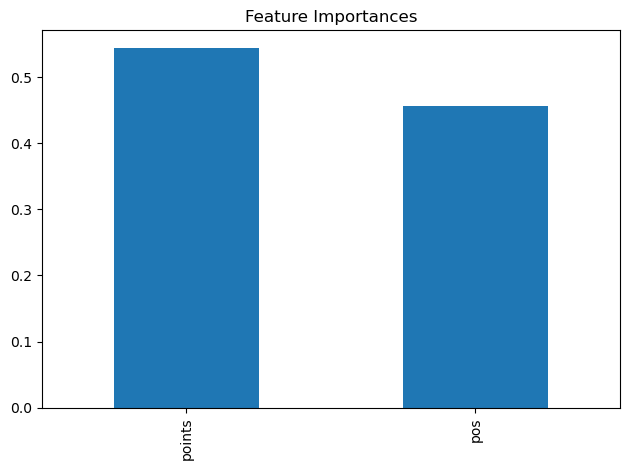

Feature importance:
 points    0.543399
pos       0.456601
dtype: float64


In [36]:
importances = clf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

feat_imp.plot(kind="bar", title="Feature Importances")
plt.tight_layout()
plt.show()
print("Feature importance:\n", feat_imp)


In [37]:
current_df = df[df["season"] == "2023-2024"].copy()
current_X = current_df[feature_cols].fillna(0)

current_df["win_prob"] = clf.predict_proba(current_X)[:, 1]

preds = current_df[["team"] + feature_cols + ["win_prob"]]\
        .sort_values("win_prob", ascending=False)

print("\n🏆 Prediction: Top 5 candidates to win the Premier League 2023–2024:")
print(preds.head(5))



🏆 Prediction: Top 5 candidates to win the Premier League 2023–2024:
                team  points  pos  win_prob
100  Manchester City      91    1     0.270
102        Liverpool      82    3     0.105
101          Arsenal      89    2     0.075
111      Bournemouth      48   12     0.000
118          Burnley      24   19     0.000
